In [1]:
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
import scipy
from collections import namedtuple
import numpy as np
import cupy as cp
import math
import json

%run utils.ipynb

In [2]:
config = Config()

In [3]:
%%time
IMAGE_SIZE = -1
IMAGES = []
IMAGES_METADATA = []

with open(os.path.join(config.dataset_path, config.dataset_metadata_file_name)) as f:
    metadata = json.load(f)

for image_fname in tqdm(os.listdir(config.dataset_path)):
    image_fname = os.path.join(config.dataset_path, image_fname)

    if not image_fname.endswith('.png'):
        continue

    # Following fuss with "with" is required to prevent "Too many open files" problem
    with Image.open(image_fname) as image:
        image.load()
        assert image.width == image.height
        assert image.width == IMAGE_SIZE or IMAGE_SIZE == -1
        IMAGE_SIZE = image.width
        assert image.mode == 'L'
        image_index = len(IMAGES)
        IMAGES.append(np.array(image).ravel())
        metadata_record = metadata[os.path.basename(image_fname)]
        metadata_record = np.rec.array([(image_fname, metadata_record.get('value', '?'))], dtype=[('file_name', 'object'), ('value', 'object')])
        IMAGES_METADATA.append(metadata_record)
        
    assert image.fp is None

assert len(IMAGES) == len(IMAGES_METADATA)
IMAGES = (np.array(IMAGES) / 255).astype(np.uint8)
IMAGES_METADATA = np.rec.array(np.concatenate(IMAGES_METADATA))
print(f'Loaded {len(IMAGES)} images')

  0%|          | 0/9202 [00:00<?, ?it/s]

Loaded 9201 images
CPU times: user 683 ms, sys: 148 ms, total: 830 ms
Wall time: 1.44 s


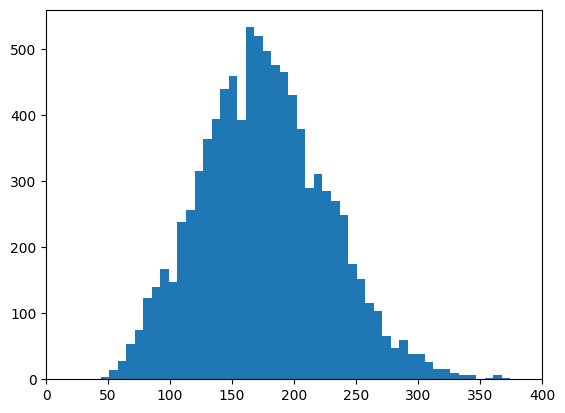

(np.float64(173.0),
 np.float64(175.95772198674058),
 np.float64(51.24122288672631))

In [16]:
images_stats = (IMAGES == 1).sum(axis=1)

images_stats_counts, images_stats_bins = np.histogram(images_stats, 50)
# plt.stairs(images_stats_counts, images_stats_bins)
plt.hist(images_stats_bins[:-1], images_stats_bins, weights=images_stats_counts)
plt.xlim(0, 400)
plt.show()

np.median(images_stats), np.mean(images_stats), np.std(images_stats)

In [19]:
def draw_kernel_bar(p1, p2, p3, p4, size=32):
    image = Image.new('L', (size, size), 0)
    draw = ImageDraw.Draw(image)
    draw.polygon([tuple(p1), tuple(p2), tuple(p3), tuple(p4)], fill=255, outline=255, width=1)
    return image
    
def get_kernel_size(kernel):
    if len(kernel.shape) == 1: # Raveled array
        size = int(math.sqrt(kernel.shape[0]))
        assert size * size == kernel.shape[0]
        return size
        
    assert len(kernel.shape) == 2
    assert kernel.shape[0] == kernel.shape[1]
    assert kernel.dtype == np.uint8
    return kernel.shape[0]

def get_kernel_shape(kernel):
    sz = get_kernel_size(kernel)
    return (sz, sz)

def kernel_as_matrix(kernel):
    if len(kernel.shape) == 1: # Raveled array
        size = int(math.sqrt(kernel.shape[0]))
        assert size * size == kernel.shape[0]
        return kernel.reshape(size, size)
        
    assert len(kernel.shape) == 2
    assert kernel.shape[0] == kernel.shape[1]
    return kernel

def kernel_as_image(kernel):
    data = (kernel * 255).astype(np.uint8)
    return Image.frombytes('L', size=get_kernel_shape(kernel), data=data)

def display_kernel_raw(kernel, precision=1):
    kernel = kernel_as_matrix(kernel)
    format_string = '{:4.' + str(precision) + 'f}'
    
    for ir, r in enumerate(kernel):
        s = f'{ir:3}'

        if ir == 0:
            header_s = '   '
            
            for ic, _ in enumerate(r):
                 header_s += ' ' + f'{ic:4}'  

            print(header_s)
            print('')
            
        for c in r:
            s += ' ' + format_string.format(c)

        print(s)            

In [20]:
BASE_KERNEL_SIZE = 32
BAR_WIDTH = 4  # relative to BASE_KERNEL_SIZE. I.e. for 32 BAR_WIDTH would be 4/32, for 16 - 4/16, etc.
OFFSET_STRIDE = 4
MAX_STRECH_FACTOR = 4
OFFSET_X_LEVELS = 1
OFFSET_Y_LEVELS = 1
STRETCH_X_LEVELS = 1
STRETCH_Y_LEVELS = 1
ROTATION_LEVELS = 1

assert STRETCH_X_LEVELS > 0 
assert STRETCH_Y_LEVELS > 0 
assert ROTATION_LEVELS > 0
assert OFFSET_X_LEVELS > 0 
assert OFFSET_Y_LEVELS > 0

In [21]:
offset_x_transfs = []
offset_y_transfs = []
stretch_x_transfs = []
stretch_y_transfs = []
rotation_transfs = []
identity_transf = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

offset_x_transfs.append(identity_transf)

for i in range(OFFSET_X_LEVELS // 2):
    l = (i + 1) * (OFFSET_STRIDE / BASE_KERNEL_SIZE)
    r = -l
    transf = [
        [1, 0, l],
        [0, 1, 0],
        [0, 0, 1]
    ]
    offset_x_transfs.append(np.array(transf))
    transf = [
        [1, 0, r],
        [0, 1, 0],
        [0, 0, 1]
    ]
    offset_x_transfs.append(np.array(transf))

offset_y_transfs.append(identity_transf)

for i in range(OFFSET_Y_LEVELS // 2):
    u = (i + 1) * (OFFSET_STRIDE / BASE_KERNEL_SIZE)
    d = -u
    transf = [
        [1, 0, 0],
        [0, 1, u],
        [0, 0, 1]
    ]
    offset_y_transfs.append(np.array(transf))
    transf = [
        [1, 0, 0],
        [0, 1, d],
        [0, 0, 1]
    ]
    offset_y_transfs.append(np.array(transf))

# cover possible STRETCHES from 1x to MAX_STRETCH_FACTOR
for i in range(STRETCH_X_LEVELS):
    f = i * ((MAX_STRETCH_FACTOR - 1) / (STRETCH_X_LEVELS - 1)) + 1 if STRETCH_X_LEVELS > 1 else 1
    transf = [
        [f, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]
    stretch_x_transfs.append(np.array(transf))

# cover possible STRETCHES from 1x to MAX_STRETCH_FACTOR
for i in range(STRETCH_Y_LEVELS):
    f = i * ((MAX_STRETCH_FACTOR - 1) / (STRETCH_Y_LEVELS - 1)) + 1 if STRETCH_Y_LEVELS > 1 else 1
    transf = [
        [1, 0, 0],
        [0, f, 0],
        [0, 0, 1]
    ]
    stretch_y_transfs.append(np.array(transf))

# cover possible rotations counter clock wise (0 - is no rotation)
for i in range(ROTATION_LEVELS):
    theta = (2 * math.pi / ROTATION_LEVELS) * i
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)
    transf = [
        [cos_theta, sin_theta, 0],
        [-sin_theta, cos_theta, 0],
        [0, 0, 1]
    ]
    rotation_transfs.append(np.array(transf))

In [22]:
TRANSFS = []
break_on_transf = -1
i = 0

for a in stretch_x_transfs:
    for b in stretch_y_transfs:
        for c in rotation_transfs:
            for d in offset_x_transfs:
                for e in offset_y_transfs:
                    if break_on_transf > 0 and i == break_on_transf:
                         assert False
                    # https://learn.microsoft.com/en-us/dotnet/desktop/winforms/advanced/why-transformation-order-is-significant?view=netframeworkdesktop-4.8
                    # We need first scale, then rotate (around origin), then translate
                    transf = e @ d @ c @ b @ a
                    TRANSFS.append(transf)
                    i += 1

print(f'{len(TRANSFS)} transformations')

1 transformations


In [23]:
lw = 1 / BASE_KERNEL_SIZE # line width 
hlw = lw / 2 # half line width
hbw = BAR_WIDTH * lw / 2 # half bar width
prototype_points_bar = np.array([
    [-hbw      , +0.25      , 1],
    [-hbw      , -0.25 + hlw, 1],
    [+hbw - hlw, -0.25 + hlw, 1],
    [+hbw - hlw, +0.25      , 1],
]).T
szsz = 16
center_pt = szsz / 2
#transf = e @ d @ c @ b @ a
# transf = offset_y_transfs[3]
#transf = stretch_x_transfs[4]
# transf = offset_x_transfs[1]
# transf = stretch_x_transfs[6]
#transf = stretch_x_transfs[3]
# transf = stretch_y_transfs[5]
# transf = offset_y_transfs[5] @ stretch_y_transfs[5]
transf = identity_transf
points = (transf @ prototype_points_bar).T
# points_x = np.round(points[:,0] * szsz + center_pt).astype(np.int32)
# points_y = np.round(points[:,1] * -szsz + center_pt).astype(np.int32)
points_x = (points[:,0] * szsz + center_pt).astype(np.int32)
points_y = (points[:,1] * -szsz + center_pt).astype(np.int32)
kernel_image = draw_kernel_bar(
    (points_x[0], points_y[0]),
    (points_x[1], points_y[1]),
    (points_x[2], points_y[2]),
    (points_x[3], points_y[3]),
    size=szsz)
kernel = (np.array(kernel_image) / 255).astype(np.uint8).ravel()
#kernel_as_image(kernel).resize((320, 320))
display_kernel_raw(kernel, precision=0)

       0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15

  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  2    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  4    0    0    0    0    0    0    0    1    1    0    0    0    0    0    0    0
  5    0    0    0    0    0    0    0    1    1    0    0    0    0    0    0    0
  6    0    0    0    0    0    0    0    1    1    0    0    0    0    0    0    0
  7    0    0    0    0    0    0    0    1    1    0    0    0    0    0    0    0
  8    0    0    0    0    0    0    0    1    1    0    0    0    0    0    0    0
  9    0    0    0    0    0    0    0    1    1    0    0    0    0    0    0    0
 10    0    0    0    0    0    0    0    1    1    0    0    0    0    0  

In [24]:
%%time
KERNELS = []
KERNEL_PARAMS = []

# prototype is a simple vertical bar of half size of kernel
lw = 1 / BASE_KERNEL_SIZE # line width 
hlw = lw / 2 # half line width
hbw = BAR_WIDTH * lw / 2 # half bar width
prototype_points_bar = np.array([
    [-hbw      , +0.25      , 1],
    [-hbw      , -0.25 + hlw, 1],
    [+hbw - hlw, -0.25 + hlw, 1],
    [+hbw - hlw, +0.25      , 1],
]).T
noncomplex_kernels_count = 0
center_pt = config.kernel_size / 2
transfs = TRANSFS

for transf in tqdm(transfs, desc='bar'):
    points = (transf @ prototype_points_bar).T
    points_x = (points[:,0] * config.kernel_size + center_pt).astype(np.int32)
    points_y = (points[:,1] * -config.kernel_size + center_pt).astype(np.int32)
    kernel_image = draw_kernel_bar(
        (points_x[0], points_y[0]),
        (points_x[1], points_y[1]),
        (points_x[2], points_y[2]),
        (points_x[3], points_y[3]),
        size=config.kernel_size)
    kernel = (np.array(kernel_image) / 255).astype(np.uint8).ravel()
    ones_count = (kernel == 1).sum()
    denominator = 255 * ones_count
    KERNELS.append(kernel)
    KERNEL_PARAMS.append([ones_count, denominator])

KERNELS = np.array(KERNELS)
KERNEL_PARAMS = np.array(KERNEL_PARAMS)
assert len(KERNELS) == len(KERNEL_PARAMS)

print(f'{len(KERNELS)} kernels generated')

bar:   0%|          | 0/1 [00:00<?, ?it/s]

1 kernels generated
CPU times: user 7.71 ms, sys: 0 ns, total: 7.71 ms
Wall time: 6.79 ms



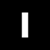

In [25]:
max_to_show = min(100, KERNELS.shape[0])

if max_to_show > 0:
    kernel_images = np.copy(KERNELS[:max_to_show])
    kernel_image_denoms = KERNEL_PARAMS[:max_to_show,1]
else:
    kernel_images = np.copy(KERNELS)
    kernel_image_denoms = KERNEL_PARAMS[:,1]

assert kernel_image_denoms.shape == (max_to_show,)
# Turn to column vector
kernel_image_denoms = kernel_image_denoms.reshape(1,-1).T
assert kernel_image_denoms.shape == (max_to_show, 1)
kernel_images *= 255 # turn to 0..255

_images = []
_captions = []

for i in range(kernel_images.shape[0]):
    _image = Image.frombytes('L', size=get_kernel_shape(kernel_images[i]), data=kernel_images[i].astype(np.uint8))
    _image = _image.resize((50, 50))
    _images.append(_image)
    _captions.append(str(i))
    
display_images_grid(_images, 16, captions=_captions)

In [26]:
NEXUSES = KERNELS

In [27]:
IMAGES_ = cp.asarray(IMAGES)

In [62]:
IMAGES_FOR_FOOTPRINTS_COUNT = 1000
IMAGES_FOR_LEARNING_COUNT = 100
MIN_CLUSTER_SIZE = 16
MAX_CLUSTER_SIZE = 16
CLUSTERS_PER_FOOTPRINT = 100
LEARN_STEPS = 10
INITIAL_NU = 0.05 # for oja it's better to set 0.01
TRIALS = 25 # till non empty clusters

image_indices = np.arange(IMAGES.shape[0])
xp = cp.get_array_module(IMAGES_)

good_cluster_masks = None
good_clusters = None

for nexus in NEXUSES:
    nexus = cp.asarray(nexus)
    image_indices_for_footprints = np.random.randint(len(IMAGES), size=IMAGES_FOR_FOOTPRINTS_COUNT)
    images_for_footprints = IMAGES_[image_indices_for_footprints]
    nexus_footprints = images_for_footprints * nexus
    nexus_footprint_sizes = nexus_footprints.sum(axis=1)

    for cluster_size in tqdm(range(MIN_CLUSTER_SIZE, MAX_CLUSTER_SIZE + 1), desc='cluster sizes'):
        good_nexus_footprints = cp.asnumpy(nexus_footprints[nexus_footprint_sizes > cluster_size])

        for trial in tqdm(range(TRIALS), leave=False, desc=f'trials, clust. size={cluster_size}'):
            cluster_masks = []
        
            for good_nexus_footprint in good_nexus_footprints: #tqdm(good_nexus_footprints, leave=False, desc=f'footprints, trial={trial}, clust. size={cluster_size}'):
                active_bit_indices = np.argwhere(good_nexus_footprint > 0).reshape(-1)
        
                for _ in range(CLUSTERS_PER_FOOTPRINT):
                    first_n_active_bit_indices = np.random.permutation(active_bit_indices)[:cluster_size] # permutation is times faster than shuffle
                    cluster_mask = np.zeros(NEXUSES.shape[1])
                    cluster_mask[first_n_active_bit_indices] = 1
                    cluster_masks.append(cluster_mask)
    
            # print(f'{len(cluster_masks)} cluster masks')

            cluster_masks = cp.asarray(cluster_masks)
            clusters = cp.ones(cluster_masks.shape)
            clusters_len = len(clusters)
        
            nu = INITIAL_NU
            image_indices = image_indices_for_footprints
    
            for learn_step in tqdm(range(LEARN_STEPS), leave=False, desc=f'learning, trial={trial}, clust. size={cluster_size}, clusters={clusters_len}'):
                #image_indices = np.random.permutation(image_indices)
            
                for ii in tqdm(image_indices[:IMAGES_FOR_LEARNING_COUNT], leave=False, desc=f'images, learn step={learn_step}, nu={nu:.3f}, trial={trial}, clust. size={cluster_size}, clusters={clusters_len}'):
                    image = IMAGES_[ii]
                    xes = image * cluster_masks
                    yeks = image @ clusters.T
    
                    # RDZB Hebb Filter
                    nomin = clusters + (xes.T * (nu * yeks)).T
                    denom = nomin.max(axis=1)
                    assert xp.array_equal(denom[0], nomin[0].max())
                    clusters = (nomin.T / denom).T
    
                # Pruning
                cluster_masks = ((clusters.T >= xp.max(clusters, axis=1) * 0.75).T).astype(cp.uint8)
                clusters = clusters * cluster_masks
            
                degenerate_cluster_indices = xp.argwhere(cluster_masks.sum(axis=1) < cluster_size)
                cluster_masks = xp.delete(cluster_masks, degenerate_cluster_indices, axis=0)
                clusters = xp.delete(clusters, degenerate_cluster_indices, axis=0)
                
                #print(f'{len(cp.asnumpy(clusters))} clusters, {len(cp.asnumpy(degenerate_cluster_indices))} dropped as degenerate')
                #cp.cuda.Stream.null.synchronize()
    
                if len(clusters) == 0:
                    break
                
                nu *= 0.9

            if len(clusters) != 0:
                def join_unique(a1, a2):
                    if a1 is None:
                        return a2
                    a1 = cp.concatenate([a1, a2])
                    return cp.unique(a1, axis=0)

                good_clusters = join_unique(good_clusters, clusters)
                good_cluster_masks = join_unique(good_cluster_masks, cluster_masks)
                
                print(f'{len(good_clusters)} good clusters found so far')

cluster sizes:   0%|          | 0/1 [00:00<?, ?it/s]

trials, clust. size=16:   0%|          | 0/25 [00:00<?, ?it/s]

learning, trial=0, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=0, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=1, nu=0.045, trial=0, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=2, nu=0.041, trial=0, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=3, nu=0.036, trial=0, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=4, nu=0.033, trial=0, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=5, nu=0.030, trial=0, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=6, nu=0.027, trial=0, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=7, nu=0.024, trial=0, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=8, nu=0.022, trial=0, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=9, nu=0.019, trial=0, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

3 good clusters found so far


learning, trial=1, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=1, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=1, nu=0.045, trial=1, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=2, nu=0.041, trial=1, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=3, nu=0.036, trial=1, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=4, nu=0.033, trial=1, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=5, nu=0.030, trial=1, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=6, nu=0.027, trial=1, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=7, nu=0.024, trial=1, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=8, nu=0.022, trial=1, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=9, nu=0.019, trial=1, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

5 good clusters found so far


learning, trial=2, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=2, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=1, nu=0.045, trial=2, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=2, nu=0.041, trial=2, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=3, nu=0.036, trial=2, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=4, nu=0.033, trial=2, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=5, nu=0.030, trial=2, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=6, nu=0.027, trial=2, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=7, nu=0.024, trial=2, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=8, nu=0.022, trial=2, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=9, nu=0.019, trial=2, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

7 good clusters found so far


learning, trial=3, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=3, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=1, nu=0.045, trial=3, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=2, nu=0.041, trial=3, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=3, nu=0.036, trial=3, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=4, nu=0.033, trial=3, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=5, nu=0.030, trial=3, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=6, nu=0.027, trial=3, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=7, nu=0.024, trial=3, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=8, nu=0.022, trial=3, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=9, nu=0.019, trial=3, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

9 good clusters found so far


learning, trial=4, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=4, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=1, nu=0.045, trial=4, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=2, nu=0.041, trial=4, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=3, nu=0.036, trial=4, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=4, nu=0.033, trial=4, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=5, nu=0.030, trial=4, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=6, nu=0.027, trial=4, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=7, nu=0.024, trial=4, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=8, nu=0.022, trial=4, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=9, nu=0.019, trial=4, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

14 good clusters found so far


learning, trial=5, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=5, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=1, nu=0.045, trial=5, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=2, nu=0.041, trial=5, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=3, nu=0.036, trial=5, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=4, nu=0.033, trial=5, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=5, nu=0.030, trial=5, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=6, nu=0.027, trial=5, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=7, nu=0.024, trial=5, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=8, nu=0.022, trial=5, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=9, nu=0.019, trial=5, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

17 good clusters found so far


learning, trial=6, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=6, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=1, nu=0.045, trial=6, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=2, nu=0.041, trial=6, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=3, nu=0.036, trial=6, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=4, nu=0.033, trial=6, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=5, nu=0.030, trial=6, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=6, nu=0.027, trial=6, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=7, nu=0.024, trial=6, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=8, nu=0.022, trial=6, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=9, nu=0.019, trial=6, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

23 good clusters found so far


learning, trial=7, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=7, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=1, nu=0.045, trial=7, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=2, nu=0.041, trial=7, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=3, nu=0.036, trial=7, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=4, nu=0.033, trial=7, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=5, nu=0.030, trial=7, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=6, nu=0.027, trial=7, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=7, nu=0.024, trial=7, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=8, nu=0.022, trial=7, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=9, nu=0.019, trial=7, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

25 good clusters found so far


learning, trial=8, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=8, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=1, nu=0.045, trial=8, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=2, nu=0.041, trial=8, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=3, nu=0.036, trial=8, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=4, nu=0.033, trial=8, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=5, nu=0.030, trial=8, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=6, nu=0.027, trial=8, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=7, nu=0.024, trial=8, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=8, nu=0.022, trial=8, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=9, nu=0.019, trial=8, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

29 good clusters found so far


learning, trial=9, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=9, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=1, nu=0.045, trial=9, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=2, nu=0.041, trial=9, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=3, nu=0.036, trial=9, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=4, nu=0.033, trial=9, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=5, nu=0.030, trial=9, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=6, nu=0.027, trial=9, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=7, nu=0.024, trial=9, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=8, nu=0.022, trial=9, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

images, learn step=9, nu=0.019, trial=9, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it/…

31 good clusters found so far


learning, trial=10, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=10, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=1, nu=0.045, trial=10, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=2, nu=0.041, trial=10, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=3, nu=0.036, trial=10, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=4, nu=0.033, trial=10, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=5, nu=0.030, trial=10, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=6, nu=0.027, trial=10, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=7, nu=0.024, trial=10, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=8, nu=0.022, trial=10, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=9, nu=0.019, trial=10, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

32 good clusters found so far


learning, trial=11, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=11, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=1, nu=0.045, trial=11, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=2, nu=0.041, trial=11, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=3, nu=0.036, trial=11, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=4, nu=0.033, trial=11, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=5, nu=0.030, trial=11, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=6, nu=0.027, trial=11, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=7, nu=0.024, trial=11, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=8, nu=0.022, trial=11, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=9, nu=0.019, trial=11, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

36 good clusters found so far


learning, trial=12, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=12, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=1, nu=0.045, trial=12, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=2, nu=0.041, trial=12, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=3, nu=0.036, trial=12, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=4, nu=0.033, trial=12, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=5, nu=0.030, trial=12, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=6, nu=0.027, trial=12, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=7, nu=0.024, trial=12, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=8, nu=0.022, trial=12, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=9, nu=0.019, trial=12, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

37 good clusters found so far


learning, trial=13, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=13, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=1, nu=0.045, trial=13, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=2, nu=0.041, trial=13, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=3, nu=0.036, trial=13, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=4, nu=0.033, trial=13, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=5, nu=0.030, trial=13, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=6, nu=0.027, trial=13, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=7, nu=0.024, trial=13, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=8, nu=0.022, trial=13, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=9, nu=0.019, trial=13, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

42 good clusters found so far


learning, trial=14, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=14, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=1, nu=0.045, trial=14, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=2, nu=0.041, trial=14, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=3, nu=0.036, trial=14, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=4, nu=0.033, trial=14, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=5, nu=0.030, trial=14, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=6, nu=0.027, trial=14, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=7, nu=0.024, trial=14, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=8, nu=0.022, trial=14, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=9, nu=0.019, trial=14, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

47 good clusters found so far


learning, trial=15, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=15, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=1, nu=0.045, trial=15, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=2, nu=0.041, trial=15, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=3, nu=0.036, trial=15, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=4, nu=0.033, trial=15, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=5, nu=0.030, trial=15, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=6, nu=0.027, trial=15, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=7, nu=0.024, trial=15, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=8, nu=0.022, trial=15, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=9, nu=0.019, trial=15, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

51 good clusters found so far


learning, trial=16, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=16, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=1, nu=0.045, trial=16, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=2, nu=0.041, trial=16, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=3, nu=0.036, trial=16, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=4, nu=0.033, trial=16, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=5, nu=0.030, trial=16, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=6, nu=0.027, trial=16, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=7, nu=0.024, trial=16, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=8, nu=0.022, trial=16, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=9, nu=0.019, trial=16, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

54 good clusters found so far


learning, trial=17, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=17, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

learning, trial=18, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=18, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=1, nu=0.045, trial=18, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=2, nu=0.041, trial=18, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=3, nu=0.036, trial=18, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=4, nu=0.033, trial=18, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=5, nu=0.030, trial=18, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=6, nu=0.027, trial=18, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=7, nu=0.024, trial=18, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=8, nu=0.022, trial=18, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=9, nu=0.019, trial=18, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

57 good clusters found so far


learning, trial=19, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=19, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=1, nu=0.045, trial=19, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=2, nu=0.041, trial=19, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=3, nu=0.036, trial=19, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=4, nu=0.033, trial=19, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=5, nu=0.030, trial=19, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=6, nu=0.027, trial=19, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=7, nu=0.024, trial=19, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=8, nu=0.022, trial=19, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=9, nu=0.019, trial=19, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

59 good clusters found so far


learning, trial=20, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=20, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=1, nu=0.045, trial=20, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=2, nu=0.041, trial=20, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=3, nu=0.036, trial=20, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=4, nu=0.033, trial=20, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=5, nu=0.030, trial=20, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=6, nu=0.027, trial=20, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=7, nu=0.024, trial=20, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=8, nu=0.022, trial=20, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=9, nu=0.019, trial=20, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

64 good clusters found so far


learning, trial=21, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=21, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=1, nu=0.045, trial=21, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=2, nu=0.041, trial=21, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=3, nu=0.036, trial=21, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=4, nu=0.033, trial=21, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=5, nu=0.030, trial=21, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=6, nu=0.027, trial=21, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=7, nu=0.024, trial=21, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=8, nu=0.022, trial=21, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=9, nu=0.019, trial=21, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

65 good clusters found so far


learning, trial=22, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=22, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

learning, trial=23, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=23, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=1, nu=0.045, trial=23, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=2, nu=0.041, trial=23, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=3, nu=0.036, trial=23, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=4, nu=0.033, trial=23, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=5, nu=0.030, trial=23, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=6, nu=0.027, trial=23, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=7, nu=0.024, trial=23, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=8, nu=0.022, trial=23, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=9, nu=0.019, trial=23, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

70 good clusters found so far


learning, trial=24, clust. size=16, clusters=91900:   0%|          | 0/10 [00:00<?, ?it/s]

images, learn step=0, nu=0.050, trial=24, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=1, nu=0.045, trial=24, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=2, nu=0.041, trial=24, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=3, nu=0.036, trial=24, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=4, nu=0.033, trial=24, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=5, nu=0.030, trial=24, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=6, nu=0.027, trial=24, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=7, nu=0.024, trial=24, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=8, nu=0.022, trial=24, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

images, learn step=9, nu=0.019, trial=24, clust. size=16, clusters=91900:   0%|          | 0/100 [00:00<?, ?it…

74 good clusters found so far



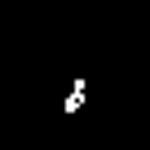
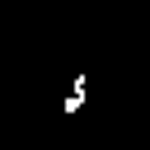
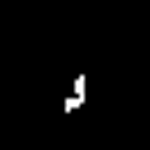
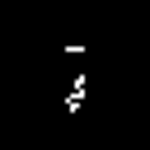
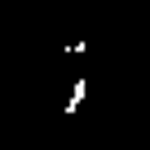
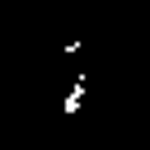
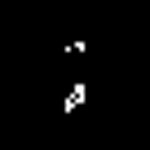
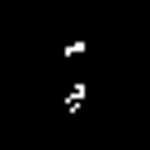
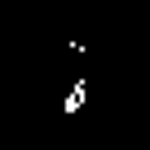
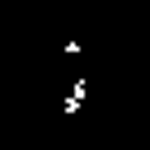
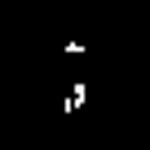
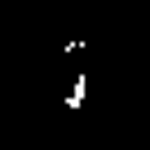
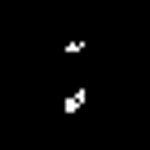
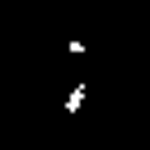
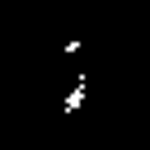
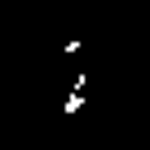
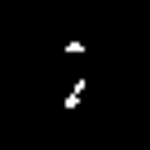
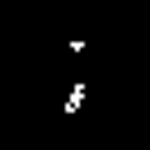
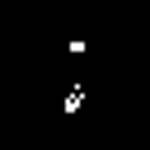
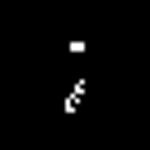
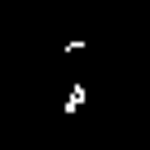
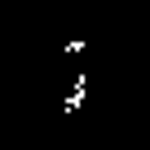
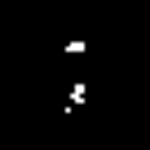
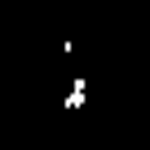
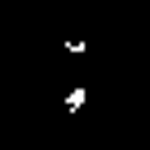
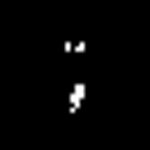
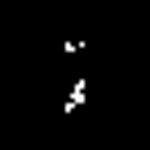
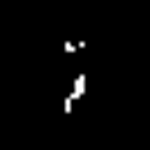
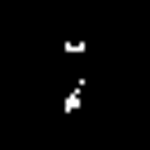
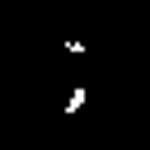
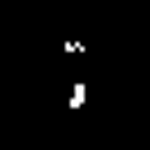
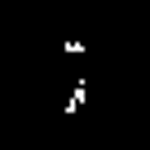
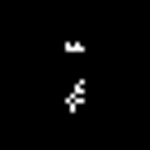
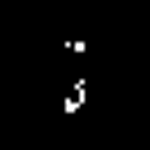
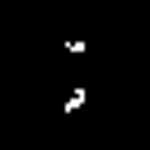
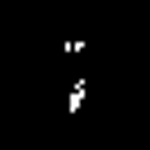
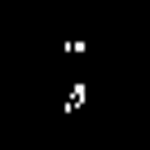
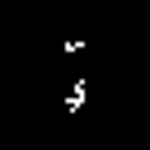
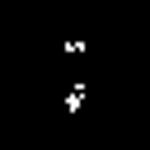
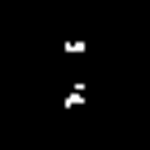
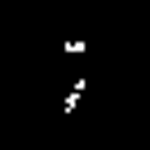
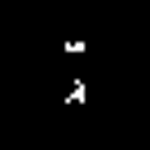
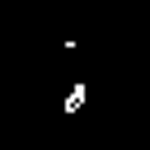
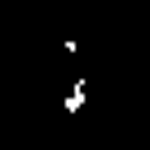
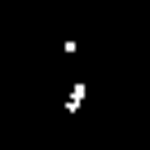
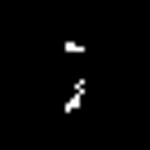
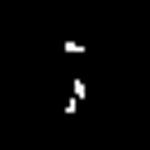
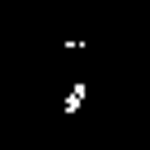
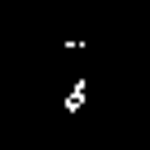
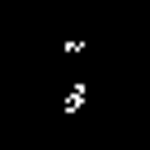
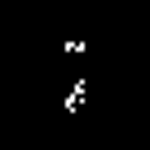
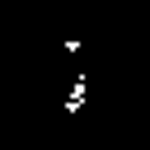
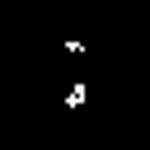
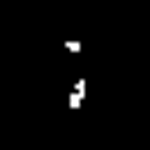
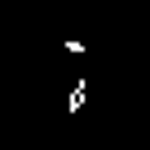
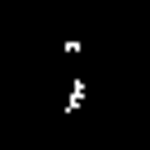
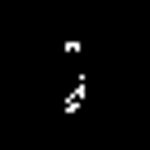
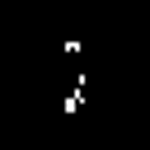
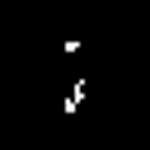
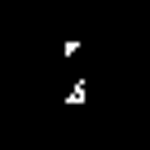
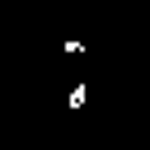
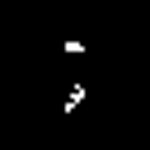
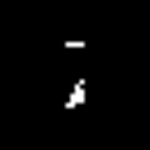
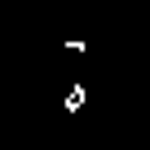
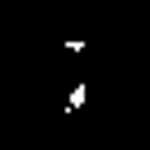
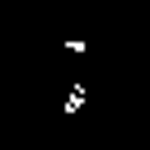
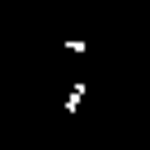
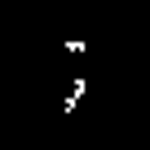
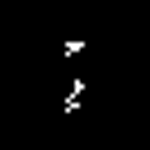
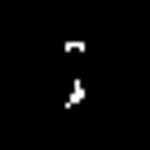
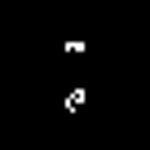
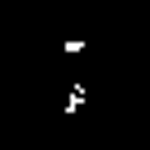
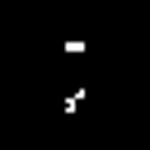
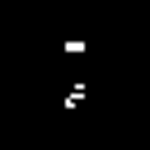

In [64]:
cluster_masks = cp.asnumpy(good_cluster_masks)

sorted_indices = np.argsort(-cluster_masks.sum(axis=1))
max_to_show = min(100, len(sorted_indices))

_images = []
_captions = []

for i in sorted_indices[:max_to_show]:
    c = cluster_masks[i]
    _image = Image.frombytes('L', size=get_kernel_shape(c), data=c.astype(np.uint8) * 255)
    _image = _image.resize((150, 150))
    _images.append(_image)
    _captions.append(f'#{i}, w: {(c == 1).sum()}')
    
display_images_grid(_images, 8, captions=_captions)

In [30]:
assert False

AssertionError: 

In [ ]:
%%time
NEXUSES = KERNELS
MIN_CLUSTER_SIZE = 8
CLUSTER_MASKS = []

clusters_per_nexus = 30
ctr = 0

for image in IMAGES_BW:
    active_nexuses = image * NEXUSES
    active_nexuses_counts = active_nexuses.sum(axis=1)
    assert active_nexuses_counts.shape == (NEXUSES.shape[0],)
    active_nexuses = active_nexuses[active_nexuses_counts >= MIN_CLUSTER_SIZE]

    for active_nexus in active_nexuses:
        active_bit_indices = np.argwhere(active_nexus > 0)

        for i in range(clusters_per_nexus):
            np.random.shuffle(active_bit_indices)
            cluster_mask = np.zeros(NEXUSES.shape[1])
            first_n_active_bit_indices = active_bit_indices[:MIN_CLUSTER_SIZE]
            cluster_mask[first_n_active_bit_indices] = 1
            CLUSTER_MASKS.append(cluster_mask)

CLUSTER_MASKS = np.array(CLUSTER_MASKS)
cluster_means = 1 / np.pow(np.sum(CLUSTER_MASKS, axis=1), 1)
cluster_sigmas = cluster_means / 3
CLUSTERS = np.random.normal(cluster_means, cluster_sigmas, size=(CLUSTER_MASKS.shape[1], CLUSTER_MASKS.shape[0])).T

print(f'{len(CLUSTERS)} clusters generated')

In [ ]:
active_nexuses_counts

In [ ]:
IMAGES_BW_XP = cp.asarray(IMAGES_BW)

In [ ]:
nu = 0.05 # for oja it's better to set 0.01
batch_size = 100
epochs = 10

image_indices = np.arange(IMAGES_BW.shape[0])
method = 'rdzb' # oja, classic, rdzb

CLUSTER_MASKS = cp.asarray(CLUSTER_MASKS)
CLUSTERS = cp.asarray(CLUSTERS)
xp = cp.get_array_module(CLUSTERS)

for batches in tqdm(range(epochs)):
    np.random.shuffle(image_indices)

    for ii in image_indices[:batch_size]:
        image = IMAGES_BW_XP[ii]
        xes = image * CLUSTER_MASKS
        yeks = image @ CLUSTERS.T

        if method == 'oja':
            grow = (nu * yeks).reshape(1, -1).T
            grow = xes * grow 
            assert np.array_equal(xes[0] * (nu * yeks[0]), grow[0])
            stabil = (nu * np.pow(yeks, 2)).reshape(1, -1).T
            stabil = CLUSTERS * stabil 
            CLUSTERS = CLUSTERS + grow - stabil
        elif method == 'classic':
            denom = np.pow(CLUSTERS + xes * (nu * yeks).reshape(1, -1).T, 2)
            denom = np.sqrt(np.sum(denom, axis=1).reshape(1, -1).T)
            assert np.array_equal(denom[0], [np.sqrt(np.pow(CLUSTERS[0] + xes[0] * (nu * yeks[0]), 2).sum())])
            nomin = CLUSTERS + xes * (nu * yeks).reshape(1, -1).T
            CLUSTERS = nomin / denom
        elif method == 'rdzb':
            nomin = CLUSTERS + xes * (nu * yeks).reshape(1, -1).T
            denom = nomin.max(axis=1)
            assert xp.array_equal(denom[0], nomin[0].max())
            CLUSTERS = (nomin.T / denom).T
        else:
            assert False, method

    # Pruning
    CLUSTER_MASKS = (CLUSTERS.T >= xp.max(CLUSTERS, axis=1) * 0.75).T
    CLUSTERS = CLUSTERS * CLUSTER_MASKS

    degenerate_cluster_indices = xp.argwhere(CLUSTER_MASKS.sum(axis=1) < MIN_CLUSTER_SIZE)
    CLUSTER_MASKS = xp.delete(CLUSTER_MASKS, degenerate_cluster_indices, axis=0)
    CLUSTERS = xp.delete(CLUSTERS, degenerate_cluster_indices, axis=0)
    
    print(f'{len(cp.asnumpy(CLUSTERS))} clusters, {len(cp.asnumpy(degenerate_cluster_indices))} dropped as degenerate')

    if len(CLUSTERS.get()) == 0:
        print('All clusters removed!')
        break
    
    nu *= 0.9

In [ ]:
CLUSTER_MASKS = cp.asnumpy(CLUSTER_MASKS)
CLUSTERS = cp.asnumpy(CLUSTERS)

In [ ]:
sorted_indices = np.argsort(-CLUSTER_MASKS.sum(axis=1))
max_to_show = min(100, len(sorted_indices))

_images = []
_captions = []

for i in sorted_indices[:max_to_show]:
    c = CLUSTER_MASKS[i]
    _image = Image.frombytes('L', size=get_kernel_shape(c), data=c.astype(np.uint8) * 255)
    _image = _image.resize((150, 150))
    _images.append(_image)
    _captions.append(f'#{i}, w: {(c == 1).sum()}')
    
display_images_grid(_images, 8, captions=_captions)

In [ ]:
display_kernel_raw(CLUSTER_MASKS[225686], precision=0)

In [ ]:
# # turn to adjustable weights
# assert np.array_equal((KERNELS[0] == 0).sum(), (KERNELS == 0).sum(axis=1)[0])
# means = 1 / np.pow((KERNELS == 0).sum(axis=1), 1)
# sigmas = means / 3
# CLUSTERS = np.random.normal(means, sigmas, size=(KERNELS.shape[1], KERNELS.shape[0]))
# CLUSTERS = KERNELS * CLUSTERS.T

In [ ]:
# nu = 0.01
# batch_size = 1000
# epochs = 10
# image_indices = np.arange(IMAGES_BW.shape[0])
# method = 'plain' # oja, plain

# for batches in tqdm(range(epochs)):
#     np.random.shuffle(image_indices)
    
#     for ii in image_indices[:batch_size]:
#         image_bw = IMAGES_BW[ii]
#         xes = image_bw * KERNELS # use KERNELS as mask for input data
#         yeks = image_bw @ CLUSTERS.T

#         if method == 'oja':
#             grow = (nu * yeks).reshape(1, -1).T
#             grow = xes * grow 
#             assert np.array_equal(xes[0], image_bw * KERNELS[0])
#             assert np.array_equal(image_bw * KERNELS[0] * (nu * yeks)[0], grow[0])
#             stabil = (nu * np.pow(yeks, 2)).reshape(1, -1).T
#             stabil = KERNELS * CLUSTERS * stabil # use KERNELS as mask for clusters
    
#             CLUSTERS = CLUSTERS + grow - stabil
#         elif method == 'plain':
#             denom1 = np.pow(CLUSTERS + xes * (nu * yeks).reshape(1, -1).T, 2)
#             denom = np.sqrt(np.sum(denom1, axis=1).reshape(1, -1).T)
#             assert np.array_equal(denom[0], [np.sqrt(np.pow(CLUSTERS[0] + (nu * yeks[0] * KERNELS[0] * image_bw), 2).sum())])
#             nomin = CLUSTERS + xes * (nu * yeks).reshape(1, -1).T
#             CLUSTERS = nomin / denom
#         else:
#             assert False, method

#         # print(ii, np.unique(CLUSTERS[0]))
#         # break

#     nu *= 0.9

In [ ]:
sz = int(np.sqrt(IMAGES.shape[1]))
center_ij = int(sz * (sz / 2 + 0.5))
assert np.isclose(IMAGES.std(axis=0)[center_ij], IMAGES[:,center_ij].std())
center_ij, IMAGES[:,center_ij].mean(), IMAGES[:,center_ij].std()

In [ ]:
# mask = (IMAGES_METADATA.value != '3') & (IMAGES_METADATA.value != '9')
#mask = (IMAGES_METADATA.value == '1') | (IMAGES_METADATA.value == '5')
# mask = (IMAGES_METADATA.value == '5')
mask = np.full(IMAGES.shape[0], True)
SUBIMAGES = IMAGES[mask]
SUBIMAGES_MEAN = SUBIMAGES.mean(axis=0)
SUBIMAGES_STD = SUBIMAGES.std(axis=0)
SUBIMAGES_PREPD = preprocessing.scale(SUBIMAGES)

values = np.unique_counts(IMAGES_METADATA.value[mask])
p = plt.bar(values.values, values.counts)
plt.bar_label(p, values.counts)
plt.show()

In [ ]:
%%time
pca = PCA()
pca.fit(SUBIMAGES_PREPD)
pca_data = pca.transform(SUBIMAGES_PREPD)

In [ ]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)[:10]
per_var_names = [f'PC{i+1}' for i in range(len(per_var))]

p = plt.bar(per_var_names, per_var)
plt.bar_label(p, map(str, per_var))
plt.show()

In [ ]:
per_var.sum()

In [ ]:
pc_imgs = []
pc_captions = {}

for i in range(min(100, len(pca.components_))):
    pc = pca.components_[i].copy()
    pc *= SUBIMAGES_STD
    pc += SUBIMAGES_MEAN
    # pc[pc < 128] = 0
    # pc[pc > 0] = 255
    #display_kernel_raw(pc, 1)
    pc_img = Image.frombytes('L', size=(sz, sz), data=pc.astype(np.uint8)).resize((100, 100))
    pc_imgs.append(pc_img)
    pc_captions[id(pc_img)] = f'{pca.explained_variance_ratio_[i] * 100:.1f}%'

display_images(pc_imgs, captions=pc_captions)    

In [ ]:
display_images(map(lambda x: Image.frombytes('L', size=(sz, sz), data=x), SUBIMAGES[:100]))

In [ ]:
pca_components_mod = pca.components_.copy()

for i in range(len(pca_components_mod)):
    pc = pca_components_mod[i]
    pc *= SUBIMAGES_STD
    pc += SUBIMAGES_MEAN
    pc[pc < 128] = 0
    pc[pc > 0] = 255

In [ ]:
imgs_restored = []
imgs_restored_caps = []

for pc_count in range(10):
    for i in range(min(10, len(pca_data))):
        img_compressed = pca_data[i].copy()
        img_compressed[pc_count+1:] = 0
        img_restored = img_compressed @ pca.components_
        #img_restored = img_compressed @ pca_components_mod
        img_restored *= SUBIMAGES_STD
        img_restored += SUBIMAGES_MEAN
        img_restored[img_restored < 128] = 0
        img_restored[img_restored > 0] = 255
        imgs_restored.append(Image.frombytes('L', size=(sz, sz), data=img_restored.astype(np.uint8)).resize((100, 100)))
        imgs_restored_caps.append(f'PC {pc_count+1}, #{i}')

display_images_grid(imgs_restored, col_count=min(10, len(pca_data)), captions=imgs_restored_caps)    

In [ ]:
XY_DATA = []

for y in range(IMAGE_SIZE):
    for x in range(IMAGE_SIZE):
        i = y * IMAGE_SIZE + x
        samples_indices = np.argwhere(SUBIMAGES[:,i] > 0)
        samples_indices = samples_indices.reshape(-1)

        for si in samples_indices:
            XY_DATA.append([x, y])

XY_DATA = np.array(XY_DATA)

In [ ]:
test_image = Image.new('L', size=(IMAGE_SIZE, IMAGE_SIZE))
test_image_draw = ImageDraw.Draw(test_image)

for xy in XY_DATA[np.random.randint(len(XY_DATA), size=1000)]:
    test_image_draw.point(list(xy), fill=255)
    
test_image.resize((50, 50))

In [ ]:
%time
xy_pca = PCA()
xy_pca.fit(XY_DATA)

In [ ]:
per_var = np.round(xy_pca.explained_variance_ratio_ * 100, decimals=1)[:10]
per_var_names = [f'PC{i+1}' for i in range(len(per_var))]

p = plt.bar(per_var_names, per_var)
plt.bar_label(p, map(str, per_var))
plt.show()